hyperoptで適切な次元、パラメータをチューニングする
ベイジアンリッジ回帰 http://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html#sphx-glr-auto-examples-linear-model-plot-bayesian-ridge-py

モデルを追加してみたけど、あまりよくならない
前処理で工夫してからアンサンブルするか...

あと、もうちょっと予測部分を含めた改善をする。引数とか

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft
from scipy import stats
from hyperopt import fmin, tpe, hp, rand

from sklearn.decomposition import PCA, KernelPCA
from sklearn import svm
from sklearn import model_selection

In [2]:

# 波形の可視化
def viz_signal(X_viz_train, y_viz_train=None, X_on_draw=None, ymin=1.3, ymax=1.7):
    label_flg = False
    draw_flg = False
    if y_viz_train is not None:
        label_flg = True
    if X_on_draw is not None:
        draw_flg = True
        
    for i, x in enumerate(X_viz_train):
        plt.subplot(len(X_viz_train),1, i+1)
        plt.plot(x)
        
        # 上に書くなら
        if draw_flg:
            plt.plot(X_on_draw[i])
            
        plt.xlim(0,len(x))
        plt.ylim(ymin, ymax)
        
        if label_flg:
            plt.ylabel(int(y_viz_train[i]), fontsize=8)
        else:
            plt.ylabel(i, fontsize=8)
    
    plt.show()


# ゼロを中央値に置き換える
def zero2median(X):
    dvs = []
    for xs in X:
        xs[np.isnan(xs)] = np.nanmedian(xs)
        dvs.append(xs)
    return np.array(dvs)


# 波形データを分割
def data_generator(X_, y_=None, w_size = 4096, offset = 500):
    if y_ is None:
        # ラベルがないとき(test)
        X_sub = []
        for n, x in enumerate(X_):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
        return np.array(X_sub)
    else:
        # ラベルがあるとき(train)
        X_sub, y_sub = [], []
        for n, (x, y) in enumerate(zip(X_, y_)):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
                y_sub.append(y)
        return np.array(X_sub), np.array(y_sub)


# 標準偏差が閾値内なら使用する
def data_selection_std(X_, y_, th_max=0.3, th_min=0.001):
    X, y = [], []
    for (xp, yp) in zip(X_, y_):
        if np.std(xp) > th_min and np.std(xp) < th_max:
            X.append(xp)
            y.append(yp)
        #else:
        #    print(xp, np.std(xp))

    return np.array(X), np.array(y)

"""
# フーリエ変換
def transform_fft(X, min_win = 4096):
    dim = X.shape[1]
    X_fft = []
    for x in X:
        win = hamming(dim)
        x = x.reshape(-1,)
        xf = fft(x*win)      
        X_fft.append(np.array(xf[:dim/2]))
    X_fft = np.array(X_fft)
    return X_fft

"""     
# フーリエ変換
def transform_fft(X_):
    # サンプル長
    N = X_.shape[1]
    X_fft = []
    for x in X_:
        # 高速フーリエ変換
        win = hamming(N)
        F = np.fft.fft(x*win)#/(N/2)
        # 直流成分の振幅を揃える
        # F[0] = F[0]/2
        #amp = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in F]
        # なぜか実部だけの方が予測性能がいい
        amp = [c.real  for c in F]
        # ナイキスト周波数の範囲内のデータのみ取り出し
        X_fft.append(amp[0:int(N/2)-1])
    return np.array(X_fft)


# 平滑化フィルタ
def savgol(X):
    X_ = []
    for xf in X:
        x_f = signal.savgol_filter(xf, 21, 3, mode="mirror")
        X_.append(x_f) 
    return np.array(X_)


def data_preproc(X_, y_=None, datalen=None):
    if y_ is not None:
        X_pre, y_pre = data_generator(X_, y_, w_size=datalen, offset=datalen-1)
        X_d, y_d = data_selection_std(X_pre, y_pre) 
        X_f = savgol(X_d)
        X_fft = transform_fft(X_f)
        return X_fft, y_d     
    else:
        X_pre = data_generator(X_, w_size=datalen, offset=datalen-1)
        X_f = savgol(X_pre)
        X_fft = transform_fft(X_f)
        return X_fft


In [3]:
# データ読み込み
df_src = pd.read_csv("train.tsv", delimiter='\t')

print("train shape:", df_src.shape)
    
df = df_src.replace(0, np.nan)
X_train = zero2median(df.values[:,1:-1])
print(X_train.shape)
y_train = df.values[:,-1]

# ラベルのダブりをなくす
#y_uniq = sorted(list(set(y_train)))
#print(y_uniq)s
#plt.hist(y_train, bins=100)
#plt.show()

# 外れ値のカット
min_idx = np.where(y_train==93)[0]
max_idx = np.where(y_train==295)[0]

X_train = np.delete(X_train, [min_idx, max_idx], 0)
y_train = df.values[:,-1]
y_train = np.delete(y_train, [min_idx, max_idx], 0)

print(X_train.shape)
print(y_train.shape)

#datalen=10000
datalen=5000
X_train, y_train = data_preproc(X_train, y_train, datalen=datalen)
print(X_train.shape)
print(y_train.shape)

train shape: (144, 30002)
(144, 30000)
(142, 30000)
(142,)
(728, 2499)
(728,)


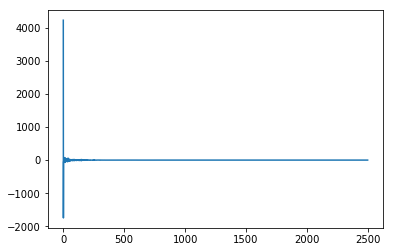

In [6]:
# データチェック
plt.plot(X_train[0])
plt.show()

In [7]:
# hyperoptで良いパラメータ推定する

#kernels_pca = ['linear','poly','rbf','sigmoid']
#kernels_svm = ['linear','poly','rbf','sigmoid']
#datalen_set = [1000, 2500, 5000, 10000, 15000, 29999]
kernels_pca = ['linear','rbf']
kernels_svm = ['linear','rbf']

space = [
    #hp.choice('datalen',datalen_set),
    hp.uniform('dim', 3, 50),
    hp.loguniform('C', np.log(1), np.log(100)),
    hp.choice('kernel_pca',kernels_pca),
    hp.choice('kernel_svm',kernels_svm),
    hp.loguniform('gamma', np.log(0.001), np.log(0.1))
]

def data_sequence(X_, y_=None, dim=None, kernel_pca=None):
    
    if y_ is not None:
        #標準化1
        X_std_ = stats.zscore(X_, axis=1)
        # 主成分分析
        pca = KernelPCA(n_components=int(dim), kernel=kernel_pca)
        X_pca_ = pca.fit_transform(X_std_)
        #標準化2
        X_std2_ = stats.zscore(X_pca_, axis=1)
        return X_std2_, y_   
    else:
        #標準化1
        X_std_ = stats.zscore(X_, axis=1)
        # 主成分分析
        pca = KernelPCA(n_components=int(dim), kernel=kernel_pca)
        X_pca_ = pca.fit_transform(X_std_)
        #標準化2
        X_std2_ = stats.zscore(X_pca_, axis=1)
        return X_std2_

count = 0
def function(args):
    print(args)
    dim, C, kernel_pca,kernel_svm,gamma = args
    
    X_, y_ = data_sequence(X_train,y_=y_train, dim=dim,kernel_pca=kernel_pca)  
    clf_ = svm.SVR(kernel=kernel_svm, gamma=gamma, C=C)
    scores = model_selection.cross_val_score(estimator=clf_, X=X_, y=y_, cv=10)
    mean_scores = scores.mean()
    global count
    print(count, mean_scores, scores.std())
    count+=1
    return -mean_scores

best = fmin(function, space, algo=tpe.suggest, max_evals=100)
print(best)


(43.032926881686514, 77.93691250782264, 'rbf', 'linear', 0.008742998846297654)
0 -0.237613097739 0.16251372194
(31.141374874922672, 2.7583028672763343, 'linear', 'linear', 0.0443575433729328)
1 -0.223402805478 0.11730250069
(9.864531455115774, 18.998588362082288, 'linear', 'rbf', 0.06406904849093009)
2 -0.161790868352 0.155292074503
(10.93644083724056, 1.0271343264707826, 'linear', 'rbf', 0.0010409408170106806)
3 -0.051333537349 0.105053790385
(16.67090659726499, 17.96480113196015, 'linear', 'rbf', 0.010452408818132577)
4 -0.154713612362 0.131259488771
(39.213679911432216, 4.107765998890645, 'rbf', 'rbf', 0.05303056345487316)
5 -0.0698369699897 0.117805304171
(31.622760045500588, 29.733762062499572, 'linear', 'linear', 0.04523668503762194)
6 -0.232822326077 0.116241901963
(8.732044443048544, 24.024349001285085, 'linear', 'linear', 0.0021233319280408182)
7 -0.0989404463296 0.105090135286
(30.09764268458603, 6.161478022746711, 'rbf', 'rbf', 0.0014658057538347842)
8 -0.0567641837492 0.115

72 -0.0530326977002 0.104303689291
(32.96936041830921, 1.3705985260456284, 'linear', 'rbf', 0.0018126340233793833)
73 -0.051254519915 0.106340372111
(33.589138534971795, 1.3225013252276407, 'linear', 'rbf', 0.00324353021023339)
74 -0.052277977508 0.107781469176
(41.28679061127161, 3.832870516699592, 'linear', 'rbf', 0.001468769268394375)
75 -0.0566241365774 0.113307661934
(35.63121550137042, 2.1272241480430822, 'linear', 'rbf', 0.0018495725998395177)
76 -0.0524569324588 0.108289002277
(39.06247289142461, 3.0517165718798265, 'linear', 'rbf', 0.0010291932594691721)
77 -0.0525689026825 0.107791001853
(46.503123184858715, 1.4792717216906026, 'rbf', 'linear', 0.0041949425227859735)
78 -0.254599891807 0.167663493022
(37.32518627706698, 5.266384962541104, 'linear', 'rbf', 0.0196079918970856)
79 -0.100329904179 0.127855670076
(32.472106014578266, 7.437589071848777, 'linear', 'rbf', 0.0024946475488788118)
80 -0.0665550522901 0.111556184119
(22.583804507438025, 1.2080711820482746, 'linear', 'rbf

In [10]:
# 作成したモデルのトレーニングデータに対する評価
dim = int(best['dim'])
kernel_pca=kernels_pca[best['kernel_pca']]
kernel_svm=kernels_svm[best['kernel_svm']]
C=best['C']
gamma=best['gamma']

X_train_, y_train_  = data_sequence(X_train,y_=y_train, dim=dim,kernel_pca=kernel_pca)
clf = svm.SVR(kernel=kernel_svm, gamma=gamma, C=C)
clf = clf.fit(X_train_, y_train_)
print(clf.score(X_train_, y_train_))

0.00493693154557


In [11]:
# データ読み込み
df_test = pd.read_csv("test.tsv", delimiter='\t')
print("test shape:", df_test.shape)

df_test = df_test.replace(0, np.nan)
X_test = zero2median(df_test.values[:,1:]) 

idx = df_test.values[:,0] # 提出用
X_test_dp = data_preproc(X_test,datalen=10000)
X_test_ = data_sequence(X_=X_test_dp,dim=dim,kernel_pca=kernel_pca)

output = clf.predict(X_test_)
output = output.reshape(X_test.shape[0],-1)
print(output.shape)

output = np.mean(output, axis=1)
print(output)

test shape: (57, 30001)
(57, 3)
[ 159.53480274  160.21262508  160.47578679  159.11963814  159.86788011
  159.77700017  159.87451801  159.69331306  160.52687221  160.02205628
  160.46753728  160.24505771  159.69991558  159.70594472  160.18472445
  161.19572875  159.98704779  160.10980691  160.21290202  159.36884767
  160.33510338  159.55424623  159.59697146  159.64586188  161.12761571
  159.97898788  160.1649258   160.12564348  160.64965367  159.70864967
  160.08865323  160.07255396  159.75053345  161.01250954  160.2155519
  160.22819097  160.34104015  159.36512927  159.76910326  160.20509338
  160.23864282  160.21845513  159.96278485  160.34687156  159.57527758
  159.60607892  160.7165602   159.55617045  159.38057362  159.27588576
  159.93706276  159.95198406  160.11560768  159.86507971  160.28800636
  159.82637723  160.27154108]


In [92]:
import csv
import time
tstr = str(time.time())

with open(tstr+"_svm_predict.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    for i, pred in zip(idx.astype(int), output.astype(int)):
        writer.writerow([i, pred])

C:\Users\keisuke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


-0.144087149481


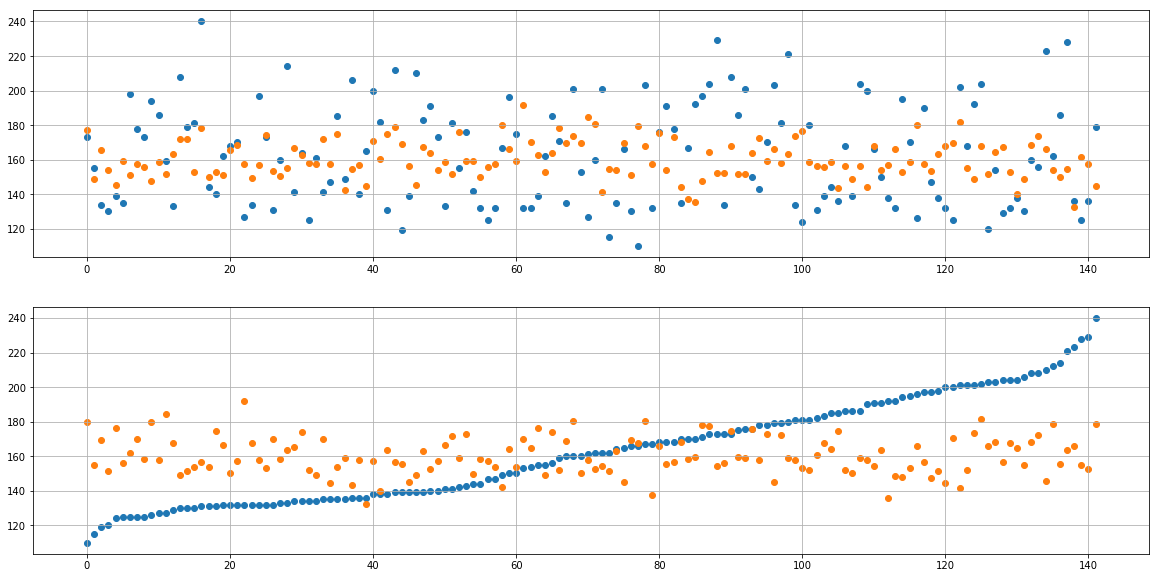

In [9]:
# 修正中

# 予測と答えを可視化してみる
#X_log_pretest = 20*np.log10(transform_fft(savgol(X_train), half=True))
X_log_pretest = transform_fft(savgol(X_train), half=True)
#
#dim=16
#X_log_pretest = stats.zscore(X_log_pretest , axis=1)
#pca = KernelPCA(n_components=dim, kernel='rbf')
pca = PCA(n_components=dim)
X_pca_pretest = pca.fit_transform(X_log_pretest)

X_std_pretest = stats.zscore(X_pca_pretest , axis=1)

import copy
# 予測と答えを可視化してみる
y_pred = clf.predict(X_std_pretest)
y_svm = y_train

print(clf.score(X_std_pretest, y_svm))

plt.figure(figsize=(20, 10))

plt.subplot(2,1,1)
plt.scatter(np.arange(len(y_svm)), y_svm)
plt.scatter(np.arange(len(y_pred)), y_pred)
plt.grid()


plt.subplot(2,1,2)
sort_idx = np.argsort(y_svm)
y_sort = copy.deepcopy(y_svm)
y_select_sort, y_pred_sort = y_sort[sort_idx], y_pred[sort_idx]
plt.scatter(np.arange(len(y_select_sort)), y_select_sort)
plt.scatter(np.arange(len(y_pred_sort)), y_pred_sort)
plt.grid()

plt.show()
